![Semillero Astrofisica](logo.PNG)

---
# Ecuaciones Diferenciales Parciales: Navier Stockes 


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver la ecuación Navier Stockes incompresible en 2D al rededor de un cilindro.

\begin{equation}
    \begin{split}
        & \rho\left(\frac{\partial}{\partial t}\vec{V}+\vec{V}\cdot\nabla\vec{V}\right) = -\vec{\nabla}P +\mu\nabla^2\vec{V} \\
        & \vec{\nabla}\cdot \vec{V} = 0
    \end{split}
\end{equation}

La notación para el código será

\begin{equation}
    \vec{V}=u\hat{i}+v\hat{j}
\end{equation}

Vamos a simular que tenemos un cilindro en un túnel de viento. Entonces, las condiciones de frontera son:

 - Dirichlet igual a zero arriba y abajo de la caja y en el cilindro y en la componente y a la entrada y la salida.
 
 - Dirichlet igual a inflow en la componente x a la entrada y la salida
 
 - Dirichlet igual a algo para la presion en la entrada
 
 - Neumann igual a cero para la presión en las demás fronteras
 
 
 Este tipo de problemas turbulentos o caóticos le dan problemas a las PINNs porque no respetan la causalidad. Una posible solución se discute en https://arxiv.org/abs/2203.07404. 

In [1]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 143 kB 30.9 MB/s 
     |████████████████████████████████| 100 kB 10.7 MB/s 


In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
#dde.config.real.set_float64()

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



## 1. Definir la Ecuación a Resolver

In [3]:
# Tamaño del Dominio
Lx_min, Lx_max = -15.0, 25.0
Ly_min, Ly_max = -8.0, 8.0

# Tiempo
tmax = 15.0

# Parámetros del fluido
rho = 1.0
mu = 0.1

def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    continuity = du_x + dv_y
    x_momentum = rho*(du_t + u*du_x + v*du_y) + dp_x - mu*(du_xx + du_yy)
    y_momentum = rho*(dv_t + u*dv_x + v*dv_y) + dp_y - mu*(dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

## 3. Definir Dominio de la Ecuación

In [4]:
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
inner = dde.geometry.Disk([0.0, 0.0], 1.0)
geom = space_domain - inner

time_domain = dde.geometry.TimeDomain(0, tmax)

geomtime = dde.geometry.GeometryXTime(geom, time_domain)

## 4. Definir Condiciones Iniciales y de Frontera

~~~python
class deepxde.icbc.boundary_conditions.PeriodicBC(geom, 
                                                  component_x, 
                                                  on_boundary, 
                                                  derivative_order=0, 
                                                  component=0)
~~~

In [5]:
#         up
#    -------------
#    |  -------  |
# in |  |inner|  | out
#    |  -------  |
#    -------------
#       down
#
def Inner(x, on_boundary): # cilinder
    return on_boundary and inner.on_boundary(x[:2])

def in_flow(x, on_boundary): # inflow
    return on_boundary and space_domain.on_boundary(x[:2]) and np.isclose(x[0],Lx_min)

def out_flow(x, on_boundary): # outflow
    return on_boundary and space_domain.on_boundary(x[:2]) and np.isclose(x[0],Lx_max)

def wall_up(x, on_boundary): # wall up
    return on_boundary and space_domain.on_boundary(x[:2]) and np.isclose(x[1],Ly_min)

def wall_down(x, on_boundary): # wall down
    return on_boundary and space_domain.on_boundary(x[:2]) and np.isclose(x[1],Ly_max)

def Initia(x, on_initial):
    return on_initial

def zero(x):
    return 0

def inflow(x):
    return 1


# Frontera de entrada
Bdr1 = dde.icbc.DirichletBC(geomtime, inflow, in_flow, component=0)
Bdr2 = dde.icbc.DirichletBC(geomtime, zero, in_flow, component=1)

# Frontera de salida
Bdr3 = dde.icbc.NeumannBC(geomtime, zero, out_flow, component=0)
Bdr4 = dde.icbc.NeumannBC(geomtime, zero, out_flow, component=2)

# Fronteras Paredes
Bdr5 = dde.icbc.NeumannBC(geomtime, zero, wall_down, component=2)
Bdr6 = dde.icbc.NeumannBC(geomtime, zero, wall_down, component=2)

Bdr7 = dde.icbc.PeriodicBC(geomtime, 0, wall_down, derivative_order=0, component=1)

#Condiciones Iniciales
ic_vx = dde.icbc.IC(geomtime, inflow, Initia, component=0)
ic_vy = dde.icbc.IC(geomtime, zero, Initia, component=1)
ic_p = dde.icbc.IC(geomtime, zero, Initia, component=2)

## 4. Crear Datos de Entrenamiento

vamos a crear los datos de entrenamiento

In [6]:
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Equation,
    [Bdr1,Bdr2,Bdr3,Bdr4,Bdr5,Bdr6,Bdr7, ic_vx, ic_vy, ic_p],
    num_domain=2600,
    num_boundary=1000,
    num_initial=300,
    train_distribution="pseudo"
)

## 5. Crear la Red Neuronal


In [7]:
layer_size = [3] + [20]*9 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## 6. Compilar y Entrenar el Modelo

Vamos a utilizar otra opción que no hemos usado hasta ahora para el optimizador Adam. Esto es que el learning rate disminuya con las iteraciones. Ver https://deepxde.readthedocs.io/en/latest/modules/deepxde.html?highlight=decay#deepxde.model.Model.compile.

In [8]:
# Modelo
model = dde.Model(data, net)

checkpointer = dde.callbacks.ModelCheckpoint(
    "model.ckpt", verbose=1, save_better_only=True, period=1000
)

# Optimizador Adam
model.compile("adam",lr=3e-4)

losshistory, train_state = model.train(iterations=30000, disregard_previous_best=True, callbacks=[checkpointer])

Compiling model...
Building feed-forward neural network...
'build' took 0.147076 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 5.608647 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [5.56e-03, 2.00e-03, 1.38e-02, 1.02e+00, 2.37e-01, 8.43e-05, 7.43e-05, 9.42e-04, 9.42e-04, 0.00e+00, 1.08e+00, 2.06e-01, 1.37e-01]    [5.56e-03, 2.00e-03, 1.38e-02, 1.02e+00, 2.37e-01, 8.43e-05, 7.43e-05, 9.42e-04, 9.42e-04, 0.00e+00, 1.08e+00, 2.06e-01, 1.37e-01]    []  
1000      [7.28e-05, 9.91e-05, 7.56e-05, 8.85e-05, 5.59e-05, 1.04e-05, 6.57e-06, 1.66e-05, 1.66e-05, 0.00e+00, 2.79e-04, 6.66e-05, 5.74e-05]    [7.28e-05, 9.91e-05, 7.56e-05, 8.85e-05, 5.59e-05, 1.04e-05, 6.57e-06, 1.66e-05, 1.66e-05, 0.00e+00, 2.79e-04, 6.66e-05, 5.74e-05]    []  
Epoch 1000: train loss improved from inf to 8.45e-04, saving model to mo

KeyboardInterrupt: ignored

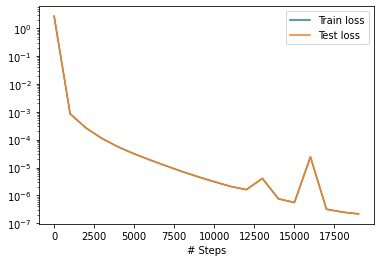

In [9]:
dde.saveplot(model.losshistory, model.train_state, issave=False, isplot=True)

In [16]:
# Optimizador LBFGS
dde.optimizers.config.set_LBFGS_options(maxiter=9000)

model.compile("L-BFGS")
losshistory, train_state = model.train(callbacks=[checkpointer])

# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)

Compiling model...
'compile' took 1.834126 s

Training model...

19534     [3.05e-08, 6.64e-08, 1.96e-08, 1.76e-08, 4.02e-09, 3.18e-09, 6.77e-10, 5.50e-09, 5.50e-09, 0.00e+00, 2.50e-08, 1.05e-08, 6.82e-09]    [3.05e-08, 6.64e-08, 1.96e-08, 1.76e-08, 4.02e-09, 3.18e-09, 6.77e-10, 5.50e-09, 5.50e-09, 0.00e+00, 2.50e-08, 1.05e-08, 6.82e-09]    []  
19578     [3.05e-08, 6.65e-08, 1.96e-08, 1.17e-08, 3.50e-09, 3.17e-09, 6.77e-10, 5.50e-09, 5.50e-09, 0.00e+00, 2.29e-08, 9.92e-09, 6.76e-09]    [3.05e-08, 6.65e-08, 1.96e-08, 1.17e-08, 3.50e-09, 3.17e-09, 6.77e-10, 5.50e-09, 5.50e-09, 0.00e+00, 2.29e-08, 9.92e-09, 6.76e-09]    []  

Best model at step 19578:
  train loss: 1.86e-07
  test loss: 1.86e-07
  test metric: []

'train' took 12.935508 s



## 7. Visualizar la Solución

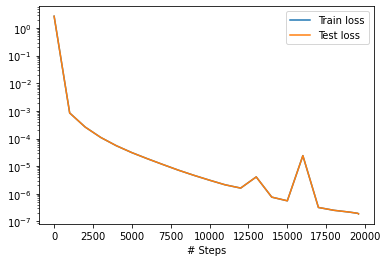

In [17]:
dde.saveplot(model.losshistory, model.train_state, issave=False, isplot=True)

In [18]:
def get_norm_V(r,T):
    r = np.hstack((r, T * np.ones((len(r[:, 0]), 1))))
    VP = model.predict(r)
    Vx, Vy, P = VP[:, 0], VP[:, 1], VP[:, 2]
    V2 = np.sqrt(Vx**2 + Vy**2)
    return V2

def get_curl(r,T):
    r = np.hstack((r, T * np.ones((len(r[:, 0]), 1))))
    X, t = r[:, 0:2], r[:, 2]
    VP = model.predict(r)
    V, P = VP[:, 0:2], VP[:, 2]
    dx, dy = np.gradient(V)
    dVx_dx, dVy_dx = dx.T
    dVx_dy, dVy_dy = dy.T
    curl = (dVx_dy - dVy_dx)
    return curl

In [ ]:
#plt.tricontourf(x, y, get_norm_V(r,4), levels=80, cmap="rainbow")    # first image on screen
#circle = plt.Circle((x0, y0), R, color='black')
#ax.add_patch(circle)

In [19]:
!pip install cmasher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


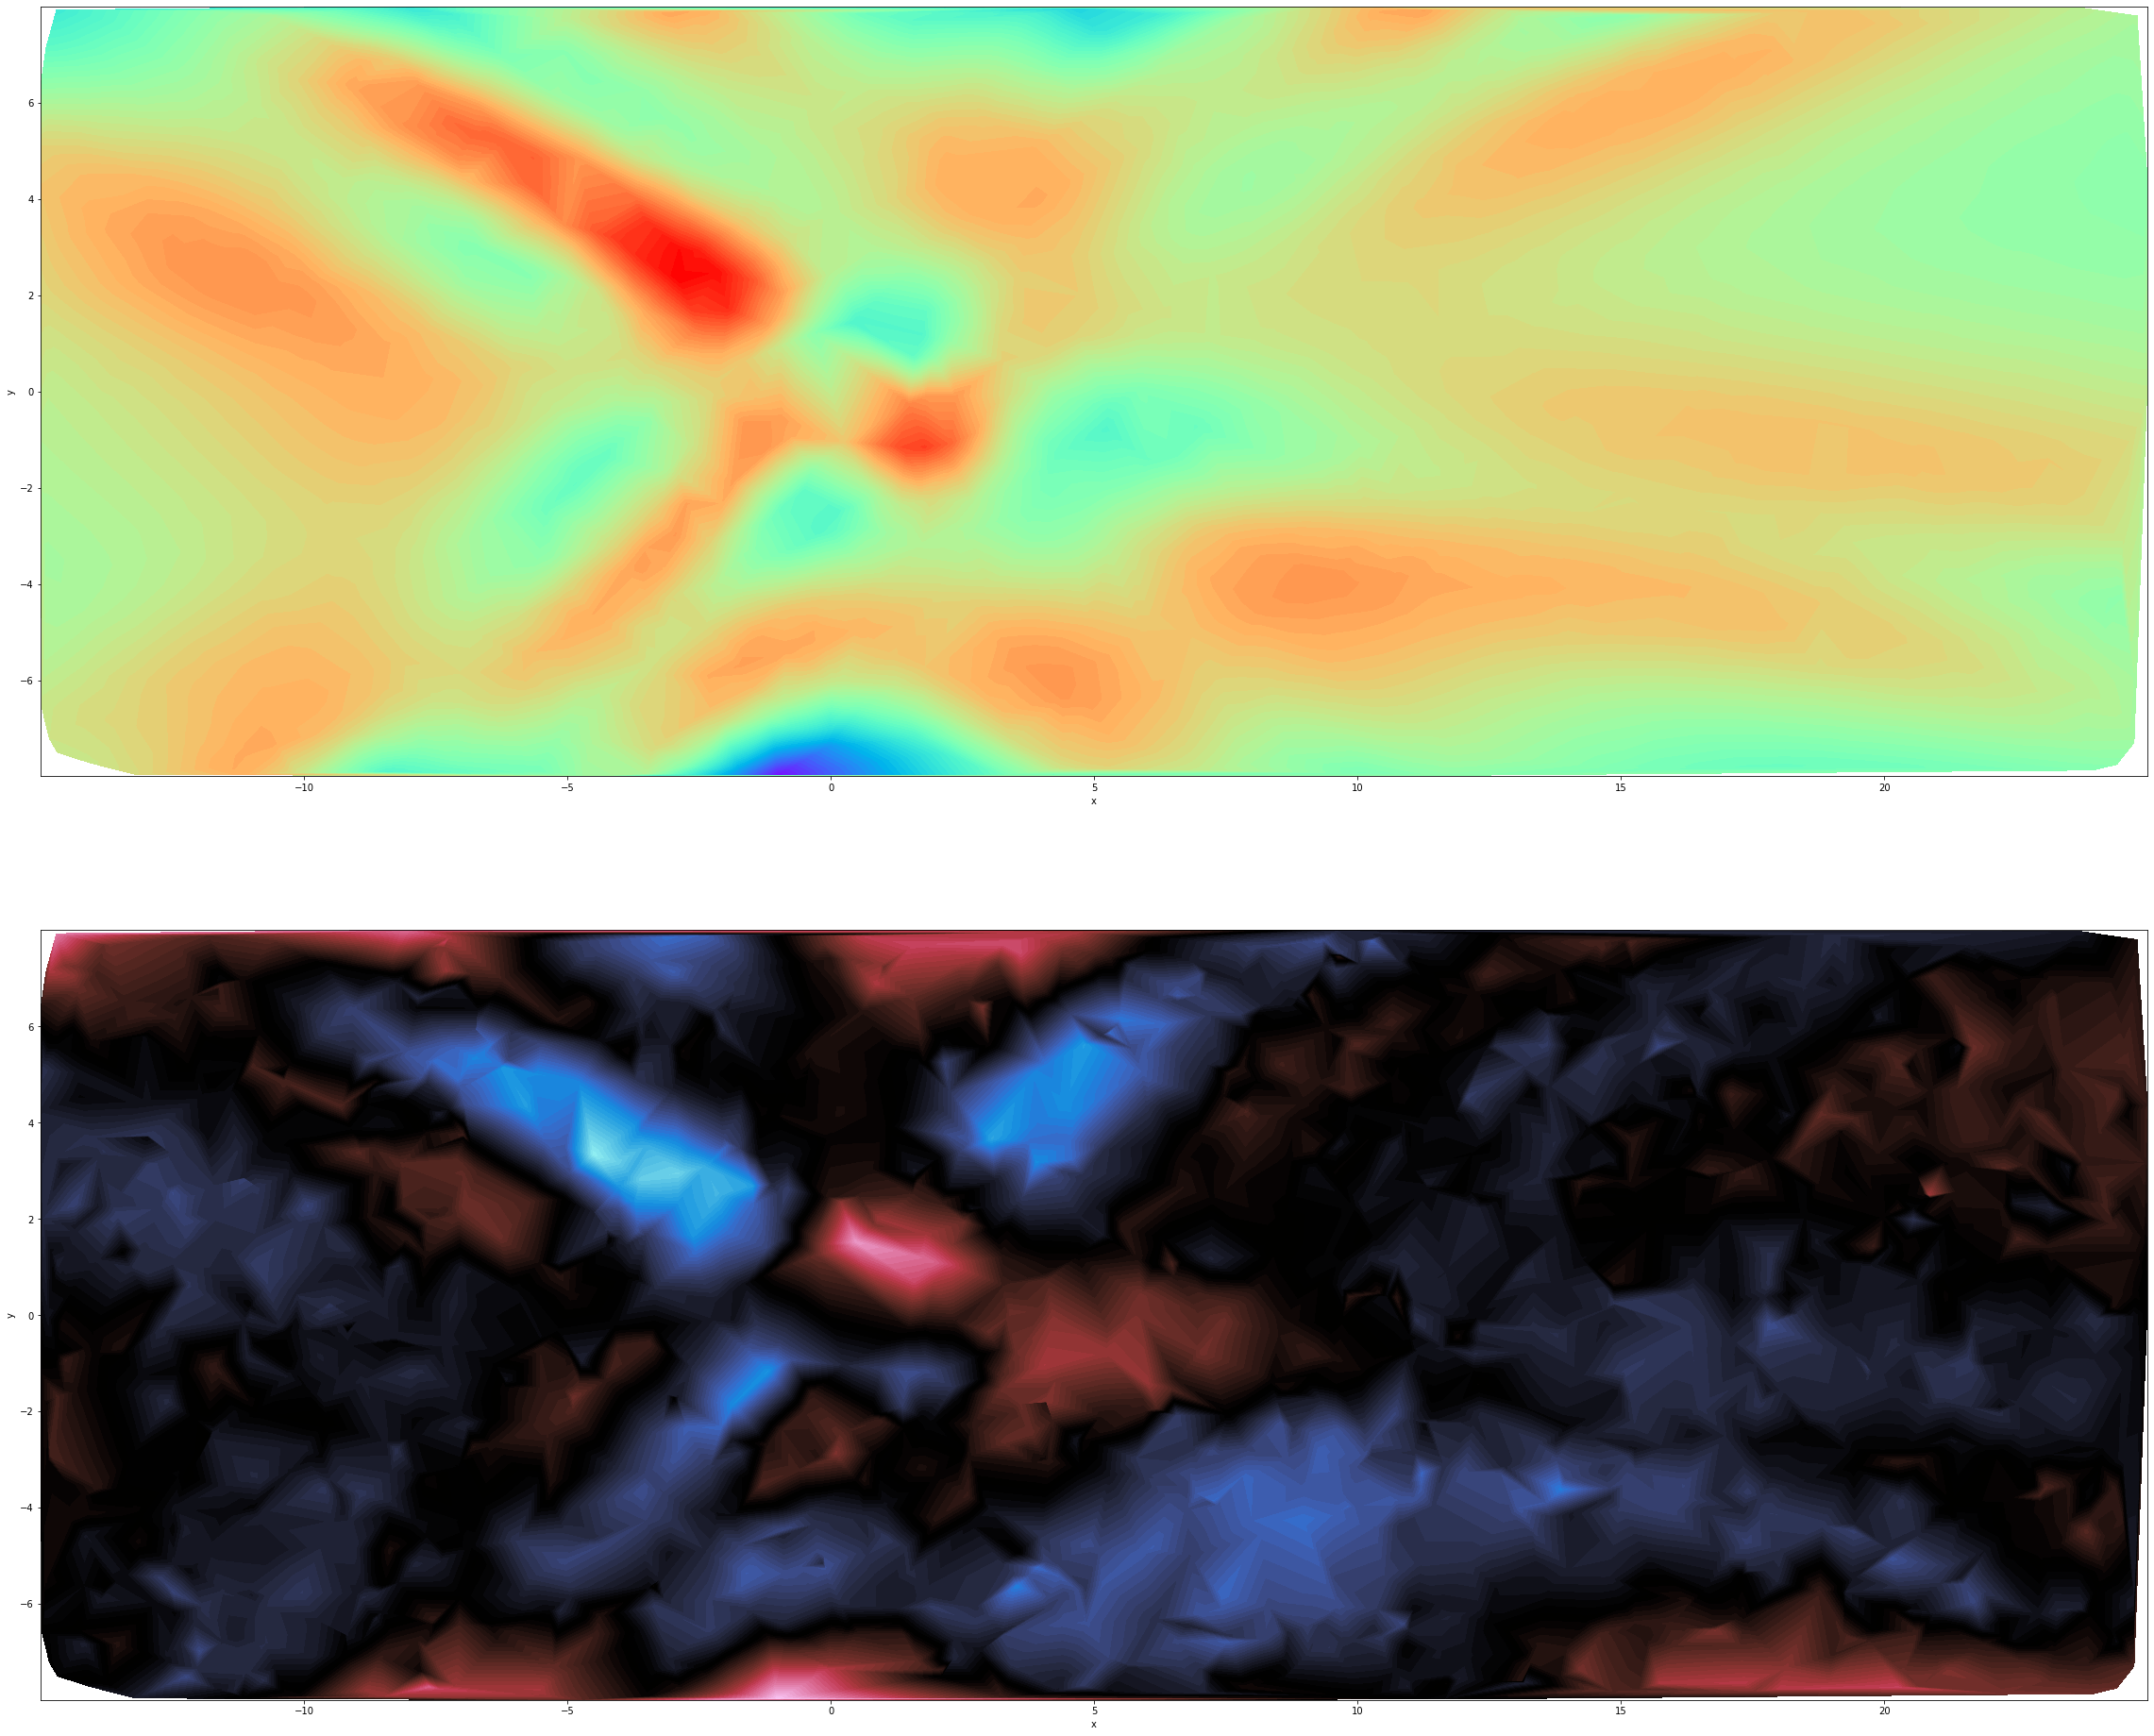

In [20]:
#%matplotlib notebook
import matplotlib.animation as animation
import cmasher as cmr

Nt = 100
t = time_domain.uniform_points(Nt)

r = geom.random_points(2000)
x, y = r[:, 0], r[:, 1]

fig = plt.figure(figsize=(Lx_max-Lx_min,2*(Ly_max-Ly_min)+1))
ax1 = fig.add_subplot(211, xlabel='x', ylabel='y')
ax2 = fig.add_subplot(212, xlabel='x', ylabel='y')

cont = ax1.tricontourf(x, y, get_norm_V(r,0), levels=80, cmap='rainbow')    # first image on screen
ax2.tricontourf(x, y, get_curl(r,0), levels=80, cmap=cmr.redshift)    # first image on screen


def init():    
    return fig,

# animation function
def animate(i,r):    
    ax1.tricontourf(x, y, get_norm_V(r,t[i]), levels=80, cmap='rainbow')
    ax2.tricontourf(x, y, get_curl(r,t[i]), levels=80, cmap=cmr.redshift)
    return fig

anim = animation.FuncAnimation(fig, animate, init_func=init, fargs=(r,), frames=Nt)

In [22]:
anim.save('animation.mp4')